# Anscombe's quartet for longitudinal experiments

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import pyfixest as pf
%matplotlib inline

In [3]:
def generate_panel_data(
    N,
    T,
    K,
    unit_fac_lb=-0.2,
    unit_fac_ub=0.2,
    time_fac_lb=-0.1,
    time_fac_ub=0.1,
    sigma=0.1,
    trend_sigma=0.01,
):
    F, L = np.random.uniform(time_fac_lb, time_fac_ub, (T, K)), np.random.uniform(
        unit_fac_lb, unit_fac_ub, (N, K)
    )
    time_trends = np.random.normal(0, trend_sigma, (N, 1)) * np.arange(T).reshape(1, T)
    epsilon = np.random.normal(0, sigma, (N, T))
    Y = np.dot(L, F.T) + epsilon + time_trends
    return Y, L


def generate_quartet(N=1000, T=20, T0=10, T1=15, K=3, **kwargs):
    np.random.seed(42)

    # Generate baseline panel data
    Y, _ = generate_panel_data(N, T, K, **kwargs)

    # Treatment effects
    group_1_effect = 0
    group_2_effect = np.random.normal(0, 0.25, N // 2)
    group_3_effect = np.linspace(-0.5, 0.5, T - T0)
    group_4_effect_T0 = np.linspace(-0.25, 0.25, T - T0)
    group_4_effect_T1 = np.linspace(-0.75, 0.75, T - T1)

    # Base data
    data = pd.DataFrame(
        {
            "unit": np.repeat(range(N), T),
            "time": np.tile(range(T), N),
            "outcome": Y.flatten(),
        }
    )

    # Randomly assign half the units to treatment
    treated_units = np.random.choice(N, N // 2, replace=False)

    # Scenario 1: Constant treatment effect (now zero)
    data1 = data.copy()
    data1["treated"] = data1["unit"].isin(treated_units) & (data1["time"] >= T0)
    data1.loc[data1["treated"], "outcome"] += group_1_effect

    # Scenario 2: Heterogeneous treatment effects across subgroups (zero mean)
    data2 = data.copy()
    data2["treated"] = data2["unit"].isin(treated_units) & (data2["time"] >= T0)
    for i, unit in enumerate(treated_units):
        data2.loc[
            (data2["unit"] == unit) & (data2["time"] >= T0), "outcome"
        ] += group_2_effect[i]

    # Scenario 3: Heterogeneous treatment effects over time (zero mean)
    data3 = data.copy()
    data3["treated"] = data3["unit"].isin(treated_units[: N // 2]) & (
        data3["time"] >= T0
    )
    for t in range(T0, T):
        data3.loc[
            (data3["treated"]) & (data3["time"] == t), "outcome"
        ] += group_3_effect[t - T0]

    # Scenario 4: Heterogeneous treatment effects over time and across cohorts (zero mean)
    data4 = data.copy()
    data4["treated_T0"] = data4["unit"].isin(treated_units[: N // 4]) & (
        data4["time"] >= T0
    )
    data4["treated_T1"] = data4["unit"].isin(treated_units[N // 4 : N // 2]) & (
        data4["time"] >= T1
    )
    data4["treated"] = data4["treated_T0"] | data4["treated_T1"]
    for t in range(T0, T):
        data4.loc[
            (data4["treated_T0"]) & (data4["time"] == t), "outcome"
        ] += group_4_effect_T0[t - T0]
    for t in range(T1, T):
        data4.loc[
            (data4["treated_T1"]) & (data4["time"] == t), "outcome"
        ] += group_4_effect_T1[t - T1]
    for d in [data1, data2, data3, data4]:
        d["ever_treated"] = d.groupby("unit")["treated"].transform("max")
    return data1, data2, data3, data4



## Post-treatment difference in means

In [4]:
def calculate_ate(data):
    treated = data[data["treated"] & (data["time"] >= T0)]["outcome"].mean()
    control = data[~data["treated"] & (data["time"] >= T0)]["outcome"].mean()
    return treated - control

In [5]:
# %% # Generate data
N, T, T0, T1 = 1000, 20, 10, 15
data1, data2, data3, data4 = generate_quartet(N, T, T0, T1, trend_sigma=0.01)
# %% # Calculate ATEs from post-treatment data
for i, data in enumerate([data1, data2, data3, data4], 1):
    ate = calculate_ate(data)
    print(f"Scenario {i}:")
    print(f"ATE: {ate:.4f}")


Scenario 1:
ATE: -0.0013
Scenario 2:
ATE: -0.0005
Scenario 3:
ATE: -0.0013
Scenario 4:
ATE: 0.0011


## Plot DGPs

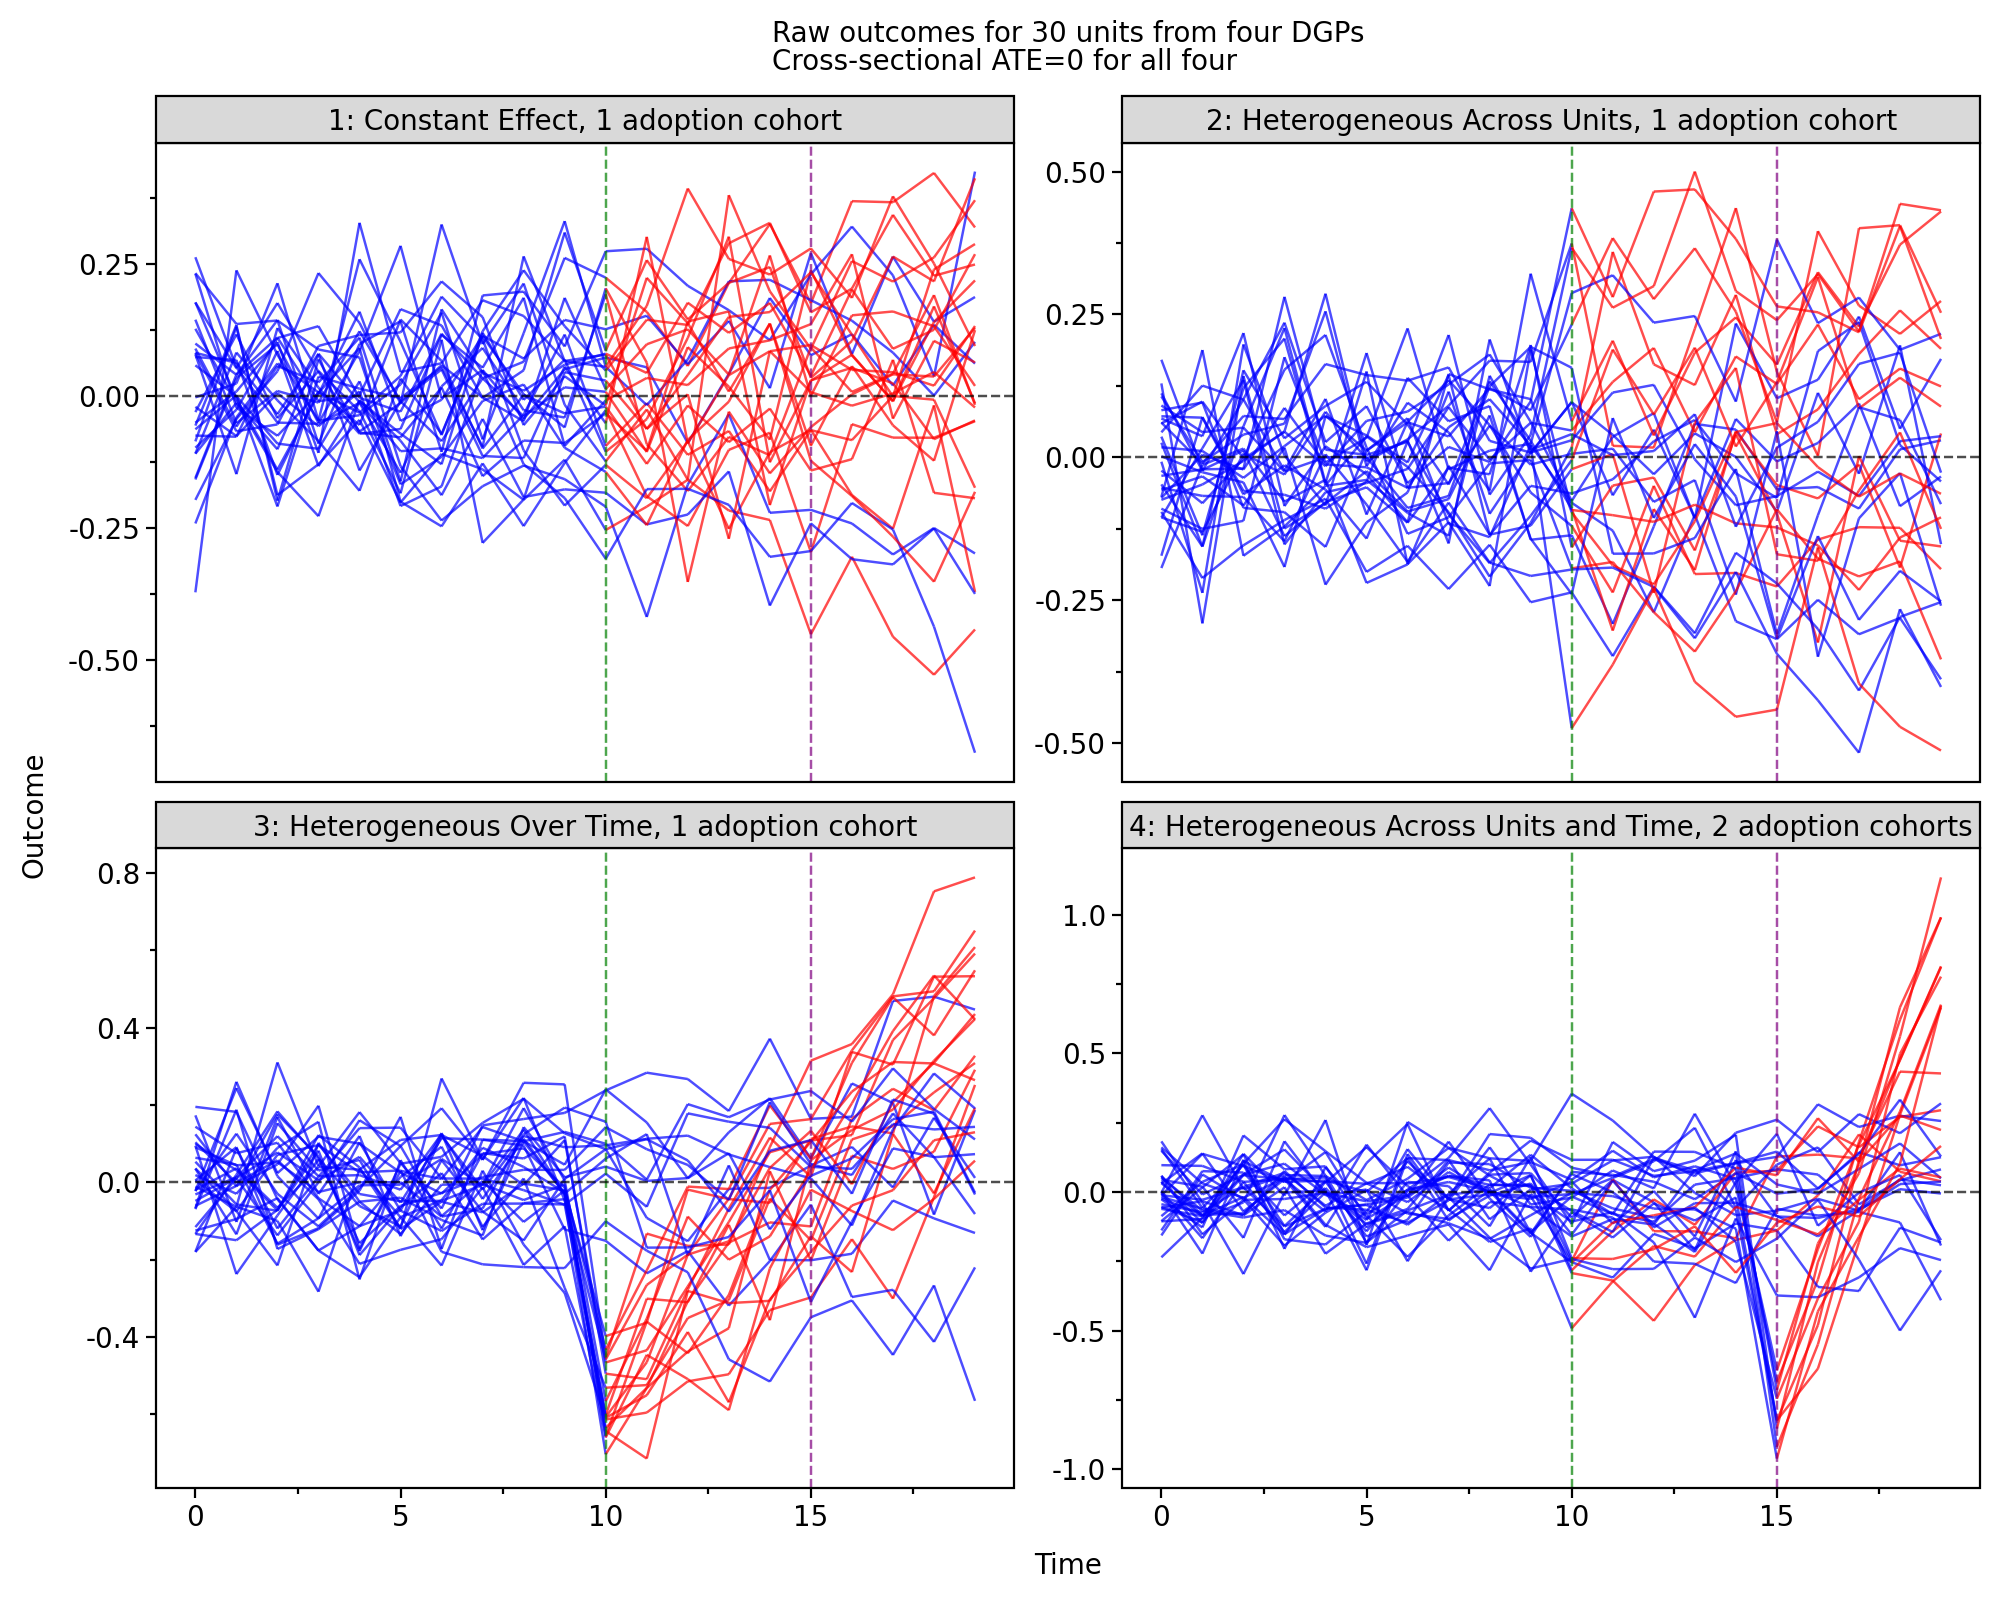

In [6]:
# %% # Plot DGPs
n_samples = 30
scenarios = [
    "1: Constant Effect, 1 adoption cohort",
    "2: Heterogeneous Across Units, 1 adoption cohort",
    "3: Heterogeneous Over Time, 1 adoption cohort",
    "4: Heterogeneous Across Units and Time, 2 adoption cohorts",
]

plot_data_list = []
for i, data in enumerate([data1, data2, data3, data4]):
    # Sample units
    all_units = data["unit"].unique()
    sampled_units = np.random.choice(all_units, n_samples, replace=False)
    # Filter data for sampled units
    scenario_data = data[data["unit"].isin(sampled_units)].copy()
    scenario_data["scenario"] = scenarios[i]
    plot_data_list.append(scenario_data)
# Combine all data
plot_data = pd.concat(plot_data_list, ignore_index=True)
# Create the plot
plot = (
    p9.ggplot(plot_data)
    + p9.aes(x="time", y="outcome", group="factor(unit)", color="factor(treated)")
    + p9.geom_line(alpha=0.7)
    + p9.geom_vline(xintercept=T0, linetype="dashed", color="green", alpha=0.7)
    + p9.geom_vline(
        data=plot_data[plot_data["scenario"] == scenarios[3]],
        xintercept=T1,
        linetype="dashed",
        color="purple",
        alpha=0.7,
    )
    + p9.geom_hline(yintercept=0, linetype="dashed", color="black", alpha=0.7)
    + p9.facet_wrap("~ scenario", scales="free_y", ncol=2)
    + p9.theme_matplotlib()
    + p9.theme(
        legend_position="none",
        figure_size=(10, 8),
    )
    + p9.labs(x="Time", y="Outcome")
    + p9.scale_color_manual(values=["blue", "red"])
)
plot = plot + p9.ggtitle(
    "Raw outcomes for 30 units from four DGPs\nCross-sectional ATE=0 for all four"
)
plot

## Event Study with `fixest`

In [12]:
def dynamic_event_study(df, ax):
    ax.clear()
    df = df.merge(
        df.assign(first_treated_period=df["time"] * df["treated"])
        .groupby("unit")["first_treated_period"]
        .apply(lambda x: x[x > 0].min()),
        on="unit",
    )
    df["rel_year"] = df["time"] - df["first_treated_period"]
    df["first_treated_period"] = (
        df["first_treated_period"].replace(np.nan, 0).astype("int")
    )
    df["rel_year"] = df["rel_year"].replace(np.nan, np.inf)
    cohort_dummies = pd.get_dummies(
        df.first_treated_period, drop_first=True, prefix="cohort_dummy"
    )
    df_int = pd.concat([df, cohort_dummies], axis=1)
    ff = f"""
                outcome ~
                {'+'.join([f"i(rel_year, {x}, ref = -1.0)" for x in df_int.filter(like = "cohort_dummy", axis = 1).columns])}
                | unit + time
                """
    m3 = pf.feols(ff, df_int, vcov={"CRV1": "unit"})
    res = m3.tidy()
    # create a dict with cohort specific effect curves
    res_dict = {}
    for c in cohort_dummies.columns:
        res_cohort = res.filter(like=c, axis=0)
        event_time = (
            res_cohort.index.str.extract(r"\[T\.(-?\d+\.\d+)\]")
            .astype(float)
            .values.flatten()
        )
        res_dict[c] = {"est": res_cohort, "time": event_time}
    i = 0
    cmp = plt.get_cmap("Set1")
    for k, v in res_dict.items():
        ax.plot(v["time"], v["est"]["Estimate"], marker=".", label=k, color=cmp(i))
        ax.fill_between(
            v["time"], v["est"]["2.5%"], v["est"]["97.5%"], alpha=0.2, color=cmp(i)
        )
        i += 1

In [13]:
N, T, T0, T1 = 1000, 20, 10, 15
data1, data2, data3, data4 = generate_quartet(N, T, T0, T1, trend_sigma=0.1, sigma=0.2)

/home/alal/Desktop/forks/pyfixest/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.inf]:cohort_dummy_10'].
            The variables are dropped from the model.
            
/home/alal/Desktop/forks/pyfixest/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.inf]:cohort_dummy_10'].
            The variables are dropped from the model.
            
/home/alal/Desktop/forks/pyfixest/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.inf]:cohort_dummy_10'].
            The variables are dropped from the model.
            
/home/alal/Desktop/forks/pyfixest/pyfixest/estimation/feols_.py:2182: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.-15.0]:coho

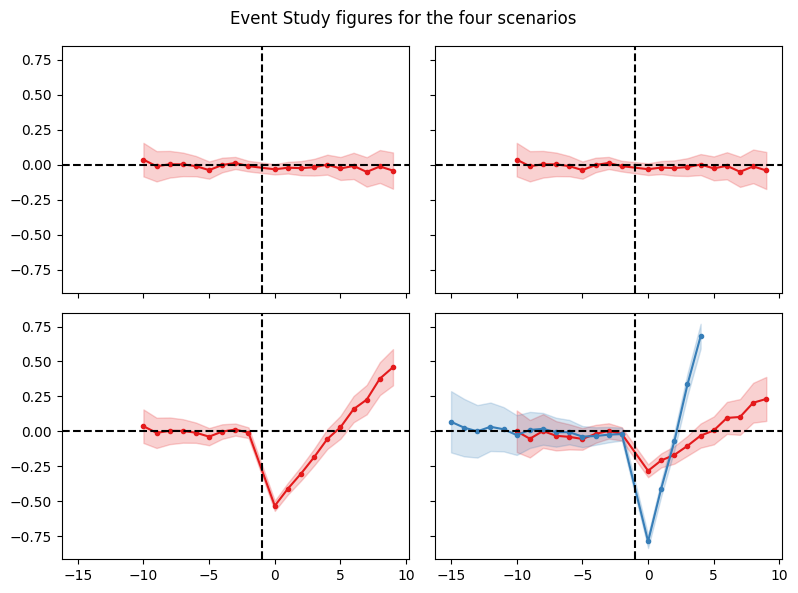

In [14]:
f, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
dynamic_event_study(data1, ax[0])
dynamic_event_study(data2, ax[1])
dynamic_event_study(data3, ax[2])
dynamic_event_study(data4, ax[3])
ax[0].axvline(-1, color="black", linestyle="--")
ax[1].axvline(-1, color="black", linestyle="--")
ax[2].axvline(-1, color="black", linestyle="--")
ax[3].axvline(-1, color="black", linestyle="--")
ax[0].axhline(0, color="black", linestyle="--")
ax[1].axhline(0, color="black", linestyle="--")
ax[2].axhline(0, color="black", linestyle="--")
ax[3].axhline(0, color="black", linestyle="--")
f.suptitle("Event Study figures for the four scenarios")
f.tight_layout()
f.show()
# f.savefig("../output/event_study.png")